In [2]:
import numpy as np
import random
import math
import matplotlib
import matplotlib.pyplot as plt
import heapq

In [156]:
# Initial conditions
n = 100 # number of trash
m = 5 # size of grid
k = 6 # number of agents (must be an even number)
mu = [3, 2] # center of trash pile
sig = [[0.1, 0], [0, 0.1]] # spread of pile
var = 0.1 # error in measurements

field = np.zeros((m,m))# array of trash pieces dispersed on field
visits = np.zeros((k,m,m))# array to track number of visits to each gridpoint
reward = np.zeros((k,m,m))# array of sum of rewards from each gridpoint
expected_mean = np.zeros((k,m,m)) # array of expected mean of each gridpoint

T = n # number of time steps
delta = 1 # amount reward decreases per visit
xi = 2 # constant xi > 1
gamma = 3 # max message length
thresh = 4 # minimum acceptable value of trash at a grid point
increment = 1 # rate at which trash is added to the 

messageSent = {}# dict {agent: list of messages to send - tuple [agent, time, arm, reward]}
messageRec = {}# dict {agent: list of messages received - tuple [agent, time, arm, reward]}

regret = []

In [157]:
for i in range(k):
    messageSent[i] = []
    messageRec[i] = []
    regret.append([0])

In [158]:
# Initialize communication network
# If graph[i][j] = 1 then there is an edge between agents i and j
# Array must be symmetric

# graph = np.ones((k,k))
# Initialize communication network
degree = 3

graph = np.identity(k)
if degree % 2 == 0:
    count = int(degree/2)
    for j in range(count):
        # make vertex for every (i +1) steps away
        for i in range(k):
            neighbor = int(i + j + 1)
            if neighbor > (k-1):
                neighbor = neighbor - k
            graph[i][neighbor] = 1
            graph[neighbor][i] = 1
else:
    count = int((degree-1)/2 + 1)
    for j in range(count):
        # make vertex for every n/2 - i steps away
        for i in range(k):
            neighbor = int(i + k/2 - j)
            if neighbor > (k-1):
                neighbor = neighbor - k
            graph[i][neighbor] = 1
            graph[neighbor][i] = 1
print(graph)



[[1. 0. 1. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1.]
 [1. 0. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0. 1.]]


In [159]:
# Initialize field
trash = np.random.multivariate_normal(mu, sig, n)
extra = np.zeros((m,m))
for i in range(n):
    x = int(trash[i][0])
    y = int(trash[i][1])
    field[x][y] += 1
    if extra[x][y] < 1:
        extra[x][y] += 1
    
print(field)

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 33. 25.  0.  0.]
 [ 0. 17. 23.  1.  0.]
 [ 0.  0.  1.  0.  0.]]


In [160]:
# Initialize agents
t = 0
for i in range(k):
    for x in range(m):
        for y in range(m):
            measure = round(np.random.normal(field[x][y], var),1)
            reward[i][x][y] += measure
            visits[i][x][y] += 1
    
    # Calculate expected mean
    expected_mean[i] = np.divide(reward[i], visits[i])
    

In [161]:
t += 1
while np.max(field) > thresh:
    print("t: {}".format(t))
    index = []
    field_new = field.reshape(m**2).tolist()
    c = heapq.nlargest(k, range(len(field_new)), key = field_new.__getitem__)
    for i in range(k):        
        # Select arm with highest expected Q value
        Q = expected_mean[i] + var*np.divide(math.sqrt(2*(xi + 1)*math.log(t)),np.sqrt(visits[i]))
        Q_new = Q.reshape(m**2).tolist()
        b = heapq.nlargest(k, range(len(Q_new)), key=Q_new.__getitem__)
        ind = np.unravel_index(b[i], Q.shape)
        measure = np.round(np.random.normal(field[ind], var),1)
        index.append(ind)
            
        print(ind)
        print(Q)
        print(measure)
        
        # Calculate regret
        optimal_ind = np.unravel_index(c[i], field.shape)
        # optimal_ind = np.unravel_index(np.argmax(field), field.shape)
        # print("opt ind: {}".format(optimal_ind))
        max_reward = field[optimal_ind]
        actual_reward = field[ind]
        # print(max_reward)
        # print(actual_reward)
        #if actual_reward < 0:
         #   actual_reward = 0
        regret[i].append(max_reward - actual_reward)
            
        # Make message to send to neighboring agents
        message = (t, i, ind, measure)
        send = messageSent[i]
        if len(send) == gamma:
            send.pop(0)
        send.append(message)
        messageSent[i] = send
        
    # Pick up trash from selected grid points
    for i in range(len(index)):
        ind = index[i]
        if field[ind] > 0:
            field[ind] -= 1
                
    
    # receive messages from neighbors and adjust expected mean
    for i in range(k):
        print(i)
        new_visits= np.zeros((m,m))
        # compare new messages with history of messages and skip any repeats
        for j in range(k):
            if graph[i][j] == 1:
                received = messageRec[i]
                sent = messageSent[j]
                for l in range(len(sent)):
                    msg = sent[l]
                    if received.count(msg) == 0:
                        received.append(msg)
                        ind = msg[2]
                        visits[i][ind] += 1
                        new_visits[ind] += 1
                        reward[i][ind] += msg[3]
                messageRec[i] = received
        
        # calculate expected mean
        reward[i] -= np.multiply(new_visits, visits[i])
        # expected_mean[i] = (expected_mean[i] -1) + np.divide(new_reward[i], visits[i])
        expected_mean[i] = np.divide(reward[i], visits[i]) + increment*extra
        print(reward[i])
        print(visits[i])
        print(expected_mean[i])
    
    field += extra*increment
    print(field)
    t += 1 



    

t: 1
(2, 1)
[[ 0.   0.1  0.   0.   0.2]
 [ 0.1  0.   0.   0.1  0.1]
 [ 0.  33.  25.1  0.1  0. ]
 [ 0.  17.  23.1  0.9  0. ]
 [ 0.   0.   1.   0.   0. ]]
32.9
(2, 2)
[[ 0.1 -0.1  0.2  0.1  0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.2 33.2 24.8 -0.1  0. ]
 [-0.1 17.  23.   1.  -0.1]
 [-0.1  0.1  1.   0.1  0.1]]
24.9
(3, 2)
[[ 0.  -0.1  0.   0.1 -0.1]
 [-0.1  0.   0.   0.   0.2]
 [ 0.1 33.  24.9  0.1  0.2]
 [ 0.2 17.2 22.9  1.1  0. ]
 [-0.1  0.   0.9  0.1 -0.2]]
23.1
(3, 1)
[[ 0.   0.   0.   0.   0.2]
 [-0.1  0.1  0.1 -0.1  0.1]
 [ 0.  32.8 24.8 -0.3  0. ]
 [ 0.1 17.  22.9  0.9  0. ]
 [ 0.1 -0.1  1.1 -0.2  0.1]]
16.8
(3, 3)
[[ 0.1 -0.1 -0.1  0.   0. ]
 [-0.2  0.   0.1 -0.1 -0.1]
 [ 0.  33.  24.9 -0.1 -0.1]
 [ 0.1 16.9 22.9  1.   0. ]
 [ 0.   0.   1.   0.1 -0.1]]
0.9
(4, 2)
[[ 0.1  0.  -0.2  0.   0.2]
 [-0.1 -0.1 -0.1 -0.1  0.1]
 [ 0.  33.1 25.1 -0.2 -0.1]
 [ 0.  17.2 23.   1.1 -0.1]
 [-0.1  0.2  0.9 -0.1  0. ]]
0.8
0
[[ 0.   0.1  0.   0.   0.2]
 [ 0.1  0.   0.   0.1  0.1]
 [ 0.  63.9 25.1  0.1

 [-0.1        -0.9        -0.15       -0.1        -1.        ]]
[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0. 21. 13.  0.  0.]
 [ 0.  1.  7.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
t: 15
(2, 1)
[[-0.71497104 -0.66497104  0.40309182 -0.71497104 -0.61497104]
 [ 0.50309182 -0.76497104 -0.66497104  0.50309182  0.50309182]
 [-0.71497104 21.08872063 18.2660585   0.50309182  0.40309182]
 [-0.56497104  1.10364648  9.63487448  0.18502896 -0.66497104]
 [-0.81497104 -0.76497104 -0.21497104 -0.76497104  0.40309182]]
20.8
(2, 2)
[[-1.40060816 -1.50060816  0.60309182 -1.70060816 -1.4339415 ]
 [-0.76497104 -1.5339415  -1.4339415  -0.76497104 -0.81497104]
 [-1.36727483 33.60309182 14.85790039  0.30309182  0.40309182]
 [-1.3339415   2.43074453 14.18026814  0.23502896 -0.71497104]
 [-0.86497104 -1.4339415  -0.8339415  -0.71497104 -0.66497104]]
13.1
(3, 1)
[[-1.4339415  -1.50060816  0.40309182 -1.70060816 -1.46727483]
 [-0.81497104 -1.5339415  -1.4339415  -0.76497104 -0.71497104]
 [-1.40060816 21.08872063

[[-5.000e+00 -1.900e+00 -1.400e+01 -5.000e+00 -8.800e+00]
 [ 1.000e-01 -2.100e+00 -9.000e+00 -1.800e+00 -4.700e+00]
 [-5.200e+00  2.396e+02  5.320e+01 -2.000e+00 -2.100e+00]
 [-8.700e+00 -1.800e+02 -1.850e+01 -7.000e+00 -9.100e+00]
 [-2.200e+00 -2.100e+00 -8.100e+00 -2.100e+00 -8.900e+00]]
[[ 3.  2.  5.  3.  4.]
 [ 1.  2.  4.  2.  3.]
 [ 3. 24.  7.  2.  2.]
 [ 4. 26. 22.  4.  4.]
 [ 2.  2.  4.  2.  4.]]
[[-1.66666667 -0.95       -2.8        -1.66666667 -2.2       ]
 [ 0.1        -1.05       -2.25       -0.9        -1.56666667]
 [-1.73333333  9.98333333  7.6        -1.         -1.05      ]
 [-2.175      -6.92307692 -0.84090909 -1.75       -2.275     ]
 [-1.1        -1.05       -2.025      -1.05       -2.225     ]]
1
[[-13.9  -9.3  -8.9  -9.8 -14. ]
 [ -5.   -9.3 -14.1  -9.1  -9. ]
 [ -9.   33.2  70.   -6.3  -8.8]
 [-13.7 -15.2  28.1 -11.9  -9.2]
 [ -9.2  -9.  -18.3  -9.1 -13.8]]
[[ 5.  4.  4.  4.  5.]
 [ 3.  4.  5.  4.  4.]
 [ 4.  1. 21.  3.  4.]
 [ 5. 18. 11.  5.  4.]
 [ 4.  4.  6.  4.

(2, 3)
[[-3.6484717  -3.69132885 -2.58690313 -2.74690313 -3.17213673]
 [-3.1388034  -2.66690313 -2.60690313 -2.60690313 -3.30547006]
 [-2.62690313  1.08900845  0.39588677 -2.28675046 -3.07213673]
 [-2.52690313 -2.55633012 -2.64023503 -2.92213673 -2.58690313]
 [-3.20547006 -2.60690313 -2.8388034  -3.17213673 -3.15547006]]
-0.1
(0, 3)
[[ -1.98675046  -2.60690313  -2.01175046  -1.93675046  -2.48690313]
 [ -2.76690313  -1.98675046  -2.01175046  -2.08675046  -2.56690313]
 [ -2.06175046   1.08294784 -10.23585954  -2.08675046  -1.93675046]
 [ -2.82690313  -2.60845157  -2.43712523  -1.81175046  -1.42489312]
 [ -2.78690313  -2.08675046  -2.20690313  -2.11175046  -2.06175046]]
0.0
(4, 3)
[[ -1.96175046  -1.39155979  -2.60690313  -2.01175046  -1.45822646]
 [ -2.03675046  -1.45822646  -1.98675046  -0.66306427  -2.01175046]
 [ -2.08675046   1.08900845 -10.23322796  -1.45822646  -1.45822646]
 [ -1.25822646  -3.37911323 -12.26985293  -2.34690313  -2.01175046]
 [ -1.45822646  -1.42489312  -1.73675046 

In [162]:
print(field)
print(t)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
45


[[0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 7.0, 0.0, 0.0, 5.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0], [0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 5.0, 0.0, 0.0, 5.0, 0.0, 0.0, 6.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 5.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

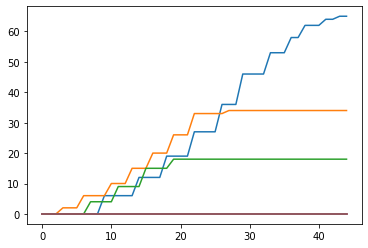

In [163]:
print(regret)
cum_regret = np.cumsum(np.array(regret), axis = 1)
print(cum_regret)
for i in range(k):
    plt.plot(np.arange(t), cum_regret[i])
plt.show()